In [14]:
# code
# for frequency analysis

In [15]:
## ----Importing necessary stuff----
import os  # Handling filesystems
import warnings
 
# Ignoring a silly warning from HVSRPY
warnings.simplefilter("ignore", UserWarning) 
warnings.simplefilter("ignore", RuntimeWarning) 

from datetime import datetime, timedelta
import numpy as np  # Numerical array management
import matplotlib.pyplot as plt  # Plot results
from matplotlib.collections import LineCollection
import matplotlib.dates as mdates
from tqdm import tqdm  # To track progress of HVSR computations
from scipy.signal import ShortTimeFFT
from scipy.signal.windows import hann
from scipy.integrate import romb, cumulative_simpson, simpson

plt.rcParams['date.converter'] = 'concise'
plt.style.use('seaborn-v0_8-paper')
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.serif'] = 'Arial'  # switch to Helvetica if running on mac

# from obspy.clients.fdsn.client import Client  # Locally stored data
# from obspy.clients.filesystem.sds import Client
from obspy import read, read_inventory, UTCDateTime  

In [16]:
FOLDER_NAME = '/Users/robby/Documents/colima-data/flows/mseed'
WINDOW_LENGTH = 512  # for individual periodograms within short-time FT
SAMPLING_FREQ = 100
HOP_LENGTH = 60   # in seconds
MFFT_SIZE = 1024  # resolution of FFT

In [17]:
inv = read_inventory('/Users/robby/Documents/colima-data/MNGR.xml')

In [18]:
def dayparser(utcdatetime):

    return utcdatetime.isoformat()[0:10]

def peak_frequencies(f_data, Sx_data):
    '''
    Returns an array of peak frequencies of a spectrogram calculated via SciPy's ShortTimeFFT

    :type f_data: numpy.ndarray
    :param f_data: frequency axis from spectrogram
    :type Sx_data: numpy.ndarray
    :param Sx_data: array of spectrogram amplitudes

    :return: peak frequencies
    '''
    ampidx = np.argmax(Sx_data, axis=0)
    f_peak = f_data[ampidx]

    return f_peak

def mean_frequencies(f_data, Sx_data):
    '''
    Returns an array of weighted mean frequencies of a spectrogram calculated via SciPy's ShortTimeFFT

    :type f_data: numpy.ndarray
    :param f_data: frequency array from periodogram
    :type Sx_data: numpy.ndarray
    :param SX_data: array of spectrogram amplitudes

    :return: mean frequencies
    '''
    f_mean = np.dot(f_data, Sx_data) / np.sum(Sx_data, axis=0)

    return f_mean

def mean_frequencies(f_data, Sx_data):
    '''
    Returns an array of weighted mean frequencies of a spectrogram calculated via SciPy's ShortTimeFFT

    :type f_data: numpy.ndarray
    :param f_data: frequency array from periodogram
    :type Sx_data: numpy.ndarray
    :param SX_data: array of spectrogram amplitudes

    :return: mean frequencies
    '''
    f_mean = np.dot(f_data, Sx_data) / np.sum(Sx_data, axis=0)

    return f_mean

def mean_amplitudes(Sx_data):
    '''
    Returns an array of mean amplitudes of a spectrogram calculated via SciPy's ShortTimeFFT

    :type a_data: numpy.ndarray
    :param a_data: frequency array from periodogram
    :type Sx_data: numpy.ndarray
    :param Sx_data: array of spectrogram amplitudes

    :return: mean amplitudes
    '''
    a_mean = np.mean(Sx_data, axis=0)

    return a_mean

In [ ]:
# Sourced from Matplotlib's API reference:
# https://matplotlib.org/stable/gallery/lines_bars_and_markers/multicolored_line.html

def colored_line_between_pts(x, y, c, ax, **lc_kwargs):
    """
    Plot a line with a color specified between (x, y) points by a third value.

    It does this by creating a collection of line segments between each pair of
    neighboring points. The color of each segment is determined by the
    made up of two straight lines each connecting the current (x, y) point to the
    midpoints of the lines connecting the current point with its two neighbors.
    This creates a smooth line with no gaps between the line segments.

    Parameters
    ----------
    x, y : array-like
        The horizontal and vertical coordinates of the data points.
    c : array-like
        The color values, which should have a size one less than that of x and y.
    ax : Axes
        Axis object on which to plot the colored line.
    **lc_kwargs
        Any additional arguments to pass to matplotlib.collections.LineCollection
        constructor. This should not include the array keyword argument because
        that is set to the color argument. If provided, it will be overridden.

    Returns
    -------
    matplotlib.collections.LineCollection
        The generated line collection representing the colored line.
    """
    if "array" in lc_kwargs:
        warnings.warn(
            'The provided "array" keyword argument will be overridden')

    # Check color array size (LineCollection still works, but values are unused)
    if len(c) != len(x) - 1:
        warnings.warn(
            "The c argument should have a length one less than the length of x and y. "
            "If it has the same length, use the colored_line function instead."
        )

    # Create a set of line segments so that we can color them individually
    # This creates the points as an N x 1 x 2 array so that we can stack points
    # together easily to get the segments. The segments array for line collection
    # needs to be (numlines) x (points per line) x 2 (for x and y)
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    lc = LineCollection(segments, **lc_kwargs)

    # Set the values used for colormapping
    lc.set_array(c)

    return ax.add_collection(lc)

In [ ]:
# Sourced from Obspy's source code


In [20]:
starttimes = []
times = []
waves = []

specsZ = []
specsN = []
specsE = []

file_list = os.listdir(FOLDER_NAME)
file_list.sort()
file_path = FOLDER_NAME + '/' + file_list[0]
st = read(file_path)
fs = st[0].stats.sampling_rate

w = hann(WINDOW_LENGTH, sym=True)
SFT = ShortTimeFFT(w, hop=HOP_LENGTH*SAMPLING_FREQ, fs=fs,
                   mfft=MFFT_SIZE, scale_to='psd')  # (mm/s)^2 / Hz
extent = SFT.extent(0)
f_lo, f_hi = extent[2:4]
freqspec = np.arange(f_lo, f_hi, SFT.delta_f)
Sx = abs(SFT.stft(st[0].data))

for file in tqdm(file_list):
    name, extension = os.path.splitext(file)
    file_path = FOLDER_NAME + '/' + file
    if extension == '.mseed':
        st = read(file_path)
        st.merge()
        st.detrend('linear')
        st.remove_sensitivity(inventory=inv)
        st.filter('highpass', freq=0.5)
        ew = st.select(component='E')[0].data
        ns = st.select(component='N')[0].data
        vt = st.select(component='Z')[0].data

        tr = st.select(component='Z')[0]
        starttime = tr.stats.starttime
        starttimes.append(starttime)
        times.append(tr.times())
        waves.append(tr.data)

        Sx_Z = abs(SFT.stft(vt))
        Sx_N = abs(SFT.stft(ns))
        Sx_E = abs(SFT.stft(ew))

        specsZ.append(Sx_Z)
        specsN.append(Sx_N)
        specsE.append(Sx_E)

peakfreqsZ = []
peakfreqsN = []
peakfreqsE = []

meanfreqsZ = []
meanfreqsN = []
meanfreqsE = []

meanampsZ = []
meanampsN = []
meanampsE = []

for s_Z, s_N, s_E in tqdm(zip(specsZ, specsN, specsE)):
    peakfZ = peak_frequencies(freqspec, s_Z)
    peakfN = peak_frequencies(freqspec, s_N)
    peakfE = peak_frequencies(freqspec, s_E)

    meanfZ = mean_frequencies(freqspec, s_Z)
    meanfN = mean_frequencies(freqspec, s_N)
    meanfE = mean_frequencies(freqspec, s_E)

    meanaZ = mean_amplitudes(s_Z)
    meanaN = mean_amplitudes(s_N)
    meanaE = mean_amplitudes(s_E)

    peakfreqsZ.append(peakfZ)
    peakfreqsN.append(peakfN)
    peakfreqsE.append(peakfE)

    meanfreqsZ.append(meanfZ)
    meanfreqsN.append(meanfN)
    meanfreqsE.append(meanfE)

    meanampsZ.append(meanaZ)
    meanampsN.append(meanaN)
    meanampsE.append(meanaE)

times_freqs = []
for ar in meanfreqsZ:
    lng = len(ar)
    tt = np.arange(0, lng*HOP_LENGTH, HOP_LENGTH)
    times_freqs.append(tt)



100%|██████████| 6/6 [00:01<00:00,  3.72it/s]
6it [00:00, 738.07it/s]


In [21]:
times_mesh = []
freqs_mesh = []
for time in times_freqs:
    tmesh, fmesh = np.meshgrid(time, freqspec)
    times_mesh.append(tmesh)
    freqs_mesh.append(fmesh)

In [22]:
for spec in specsZ:
    mini = 10*np.log10(spec).min()
    maxi = 10*np.log10(spec).max()
    print(f'{mini}, {maxi}')

-106.44562650525197, -38.20030715233759
-112.08496669992593, -43.077932481613075
-97.09742977632553, -39.64296951858905
-108.1277274588495, -42.42704279443182
-114.62682163154767, -44.64396496050564
-105.98583929799906, -42.11730574368883


In [ ]:
plt.pcolormesh(times_mesh[4],freqs_mesh[4],10*np.log10(specsZ[4]),vmin=-120,vmax=-35,cmap='cubehelix')

In [ ]:
cosa = starttimes[0]

In [ ]:
cosa.datetime

datetime.datetime(2011, 10, 12, 6, 30)

KeyboardInterrupt: 

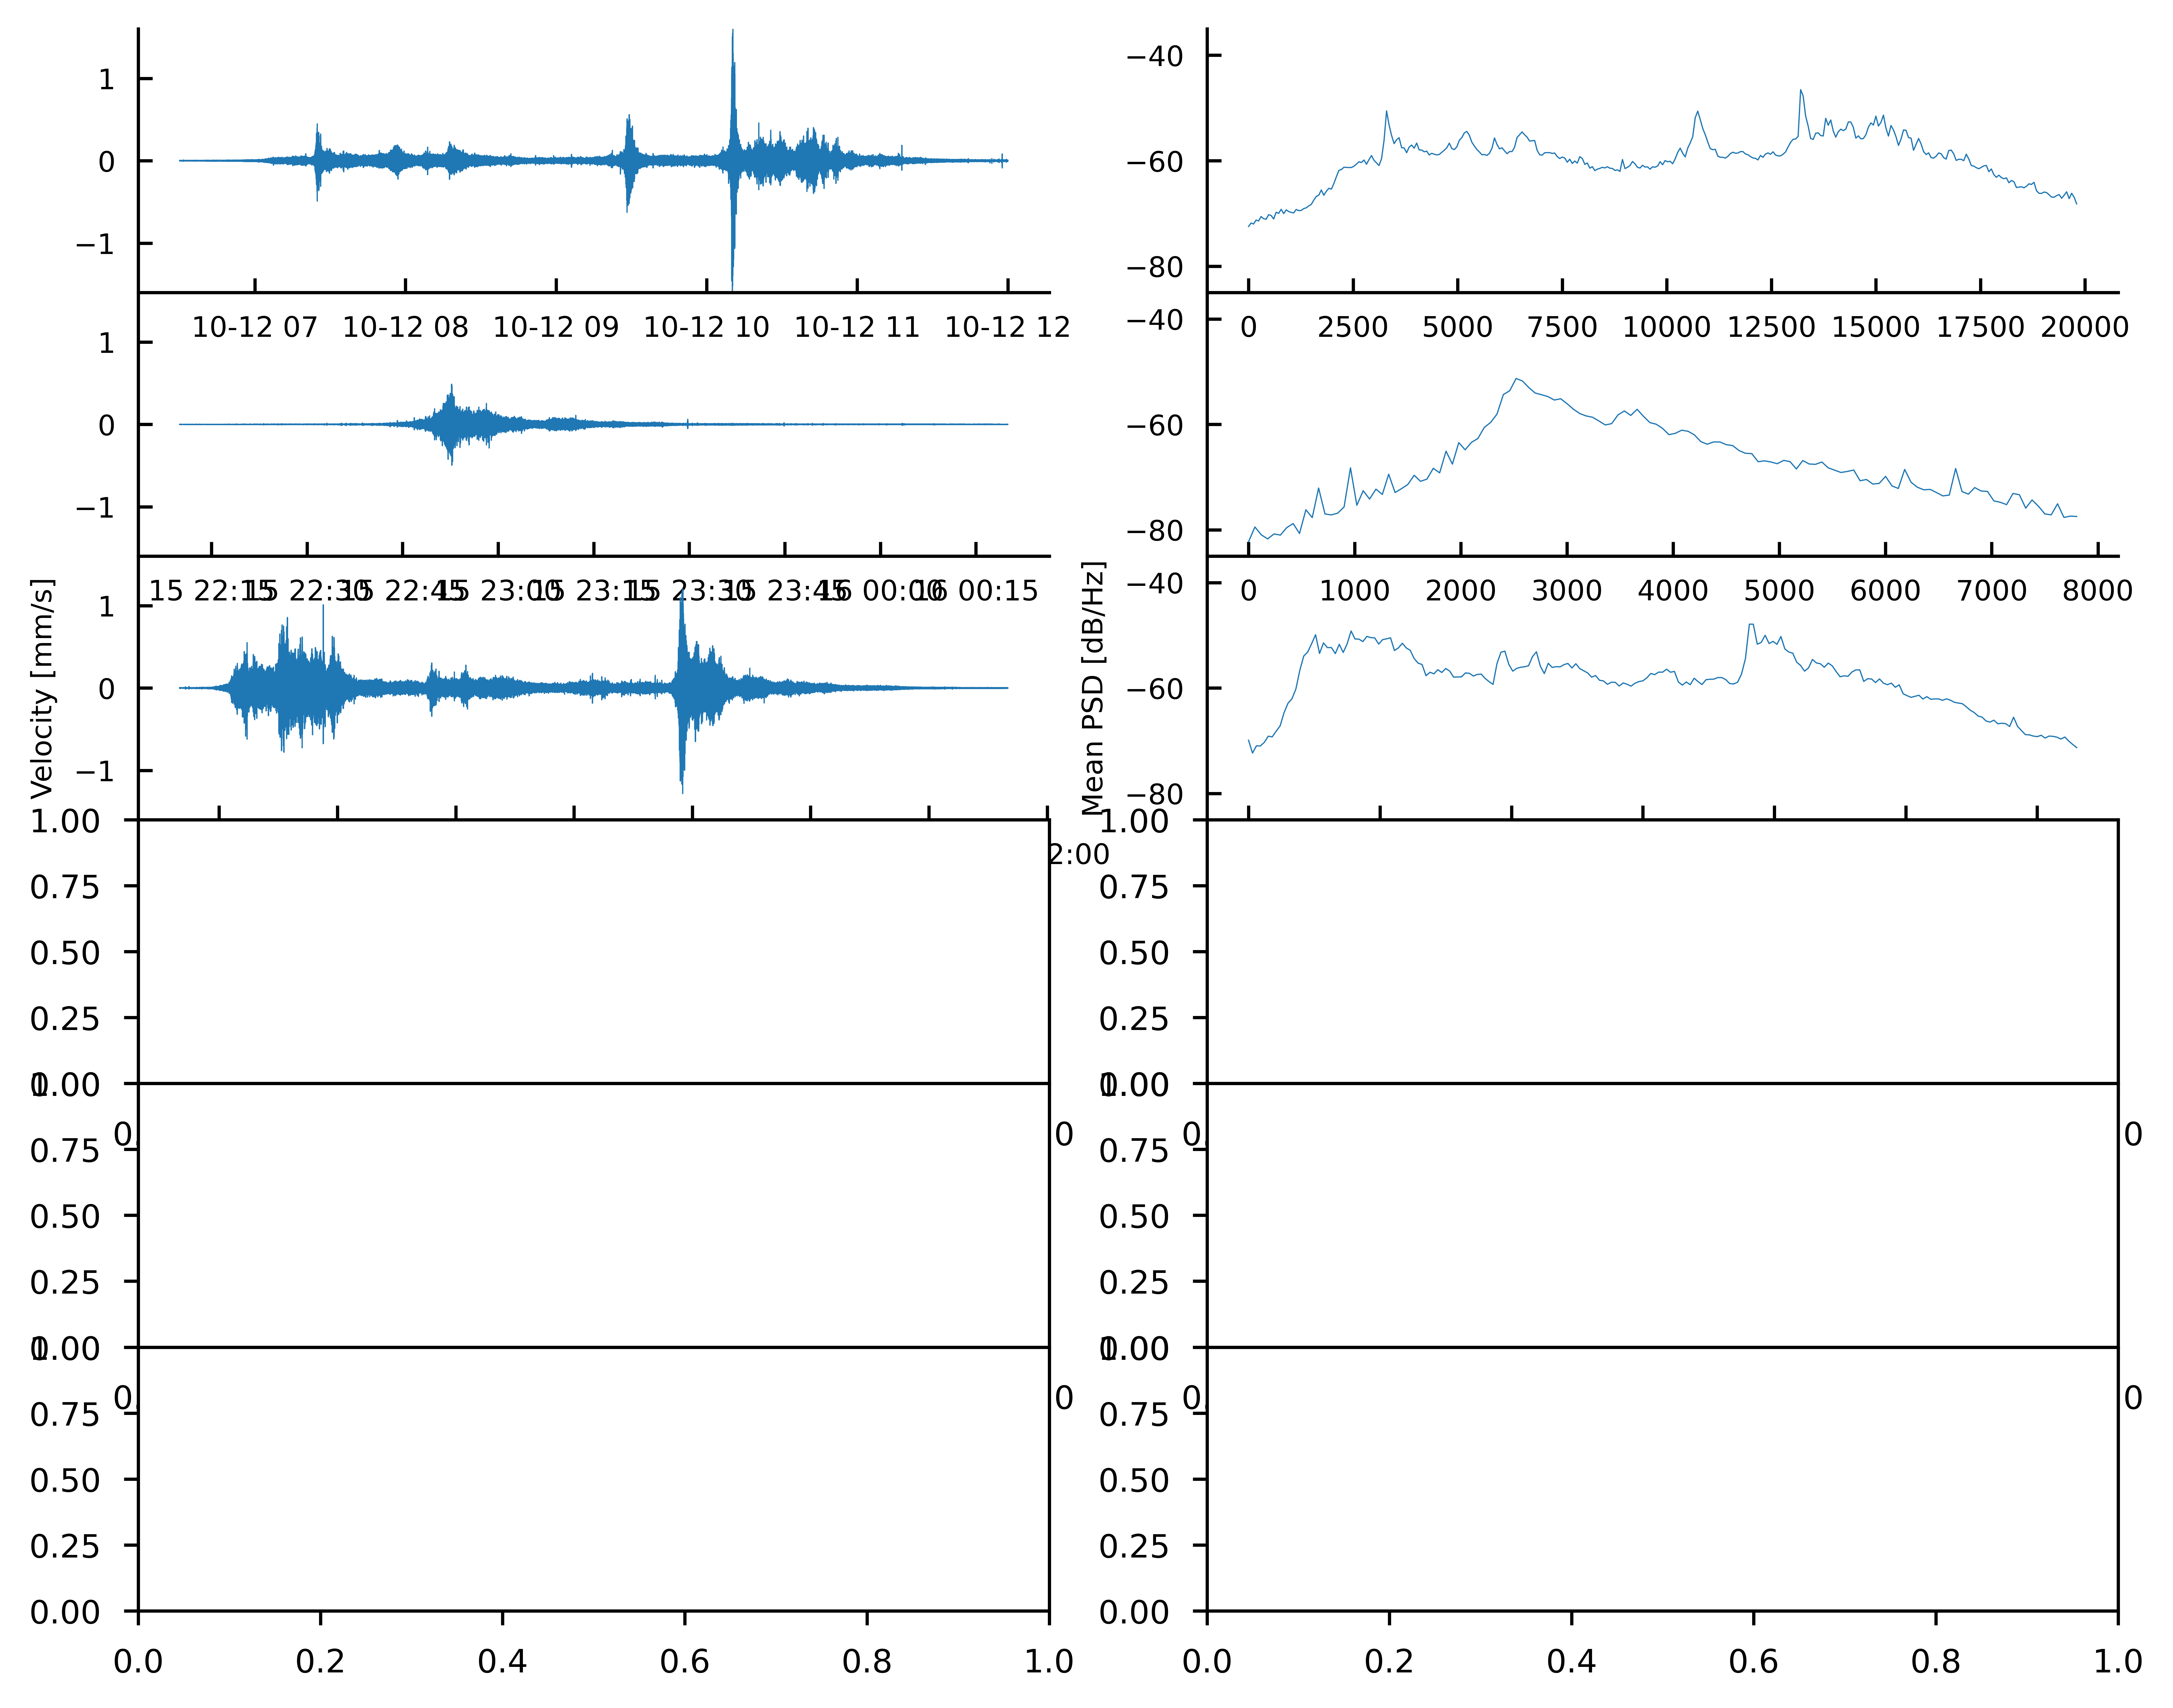

In [ ]:
fig, axs = plt.subplots(nrows=6, ncols=2, figsize = (190/25.4,6), dpi=1000)
fig.tight_layout()
fig.subplots_adjust(hspace=0)
for ii, flow in enumerate(specsZ):
    # wave
    dates = [starttimes[ii].datetime + timedelta(seconds=i) for i in times[ii]]
    axs[ii, 0].plot(dates, 1000*waves[ii], linewidth=0.3)
    axs[ii, 0].tick_params(direction='in', labelsize=7)
    axs[ii, 0].spines[['top','right']].set_visible(False)
    axs[ii, 0].set_ylim(-1.6,1.6)
    axs[ii, 0].set_facecolor((1, 1, 1, 0))
    axs[ii, 0].xaxis.set_major_formatter(mdates.AutoDateFormatter(axs[ii, 0].xaxis.get_major_locator()))
    # PSD mean
    axs[ii, 1].plot(times_freqs[ii], 10*np.log10(meanampsZ[ii]), linewidth=0.3)
    axs[ii, 1].tick_params(direction='in', labelsize=7)
    axs[ii, 1].spines[['top','right']].set_visible(False)
    axs[ii, 1].set_ylim(-85,-35)
    axs[ii, 1].set_facecolor((1, 1, 1, 0))
    # conditions
    if ii == 2:
        axs[ii, 0].set_ylabel('Velocity [mm/s]', fontsize=7)
        axs[ii, 1].set_ylabel('Mean PSD [dB/Hz]', fontsize=7)
    if ii == 5:
        axs[ii, 0].set_xlabel('Time [s]', fontsize=7)
        axs[ii, 1].set_xlabel('Time [s]', fontsize=7)
fig.savefig('figura-prueba.png')


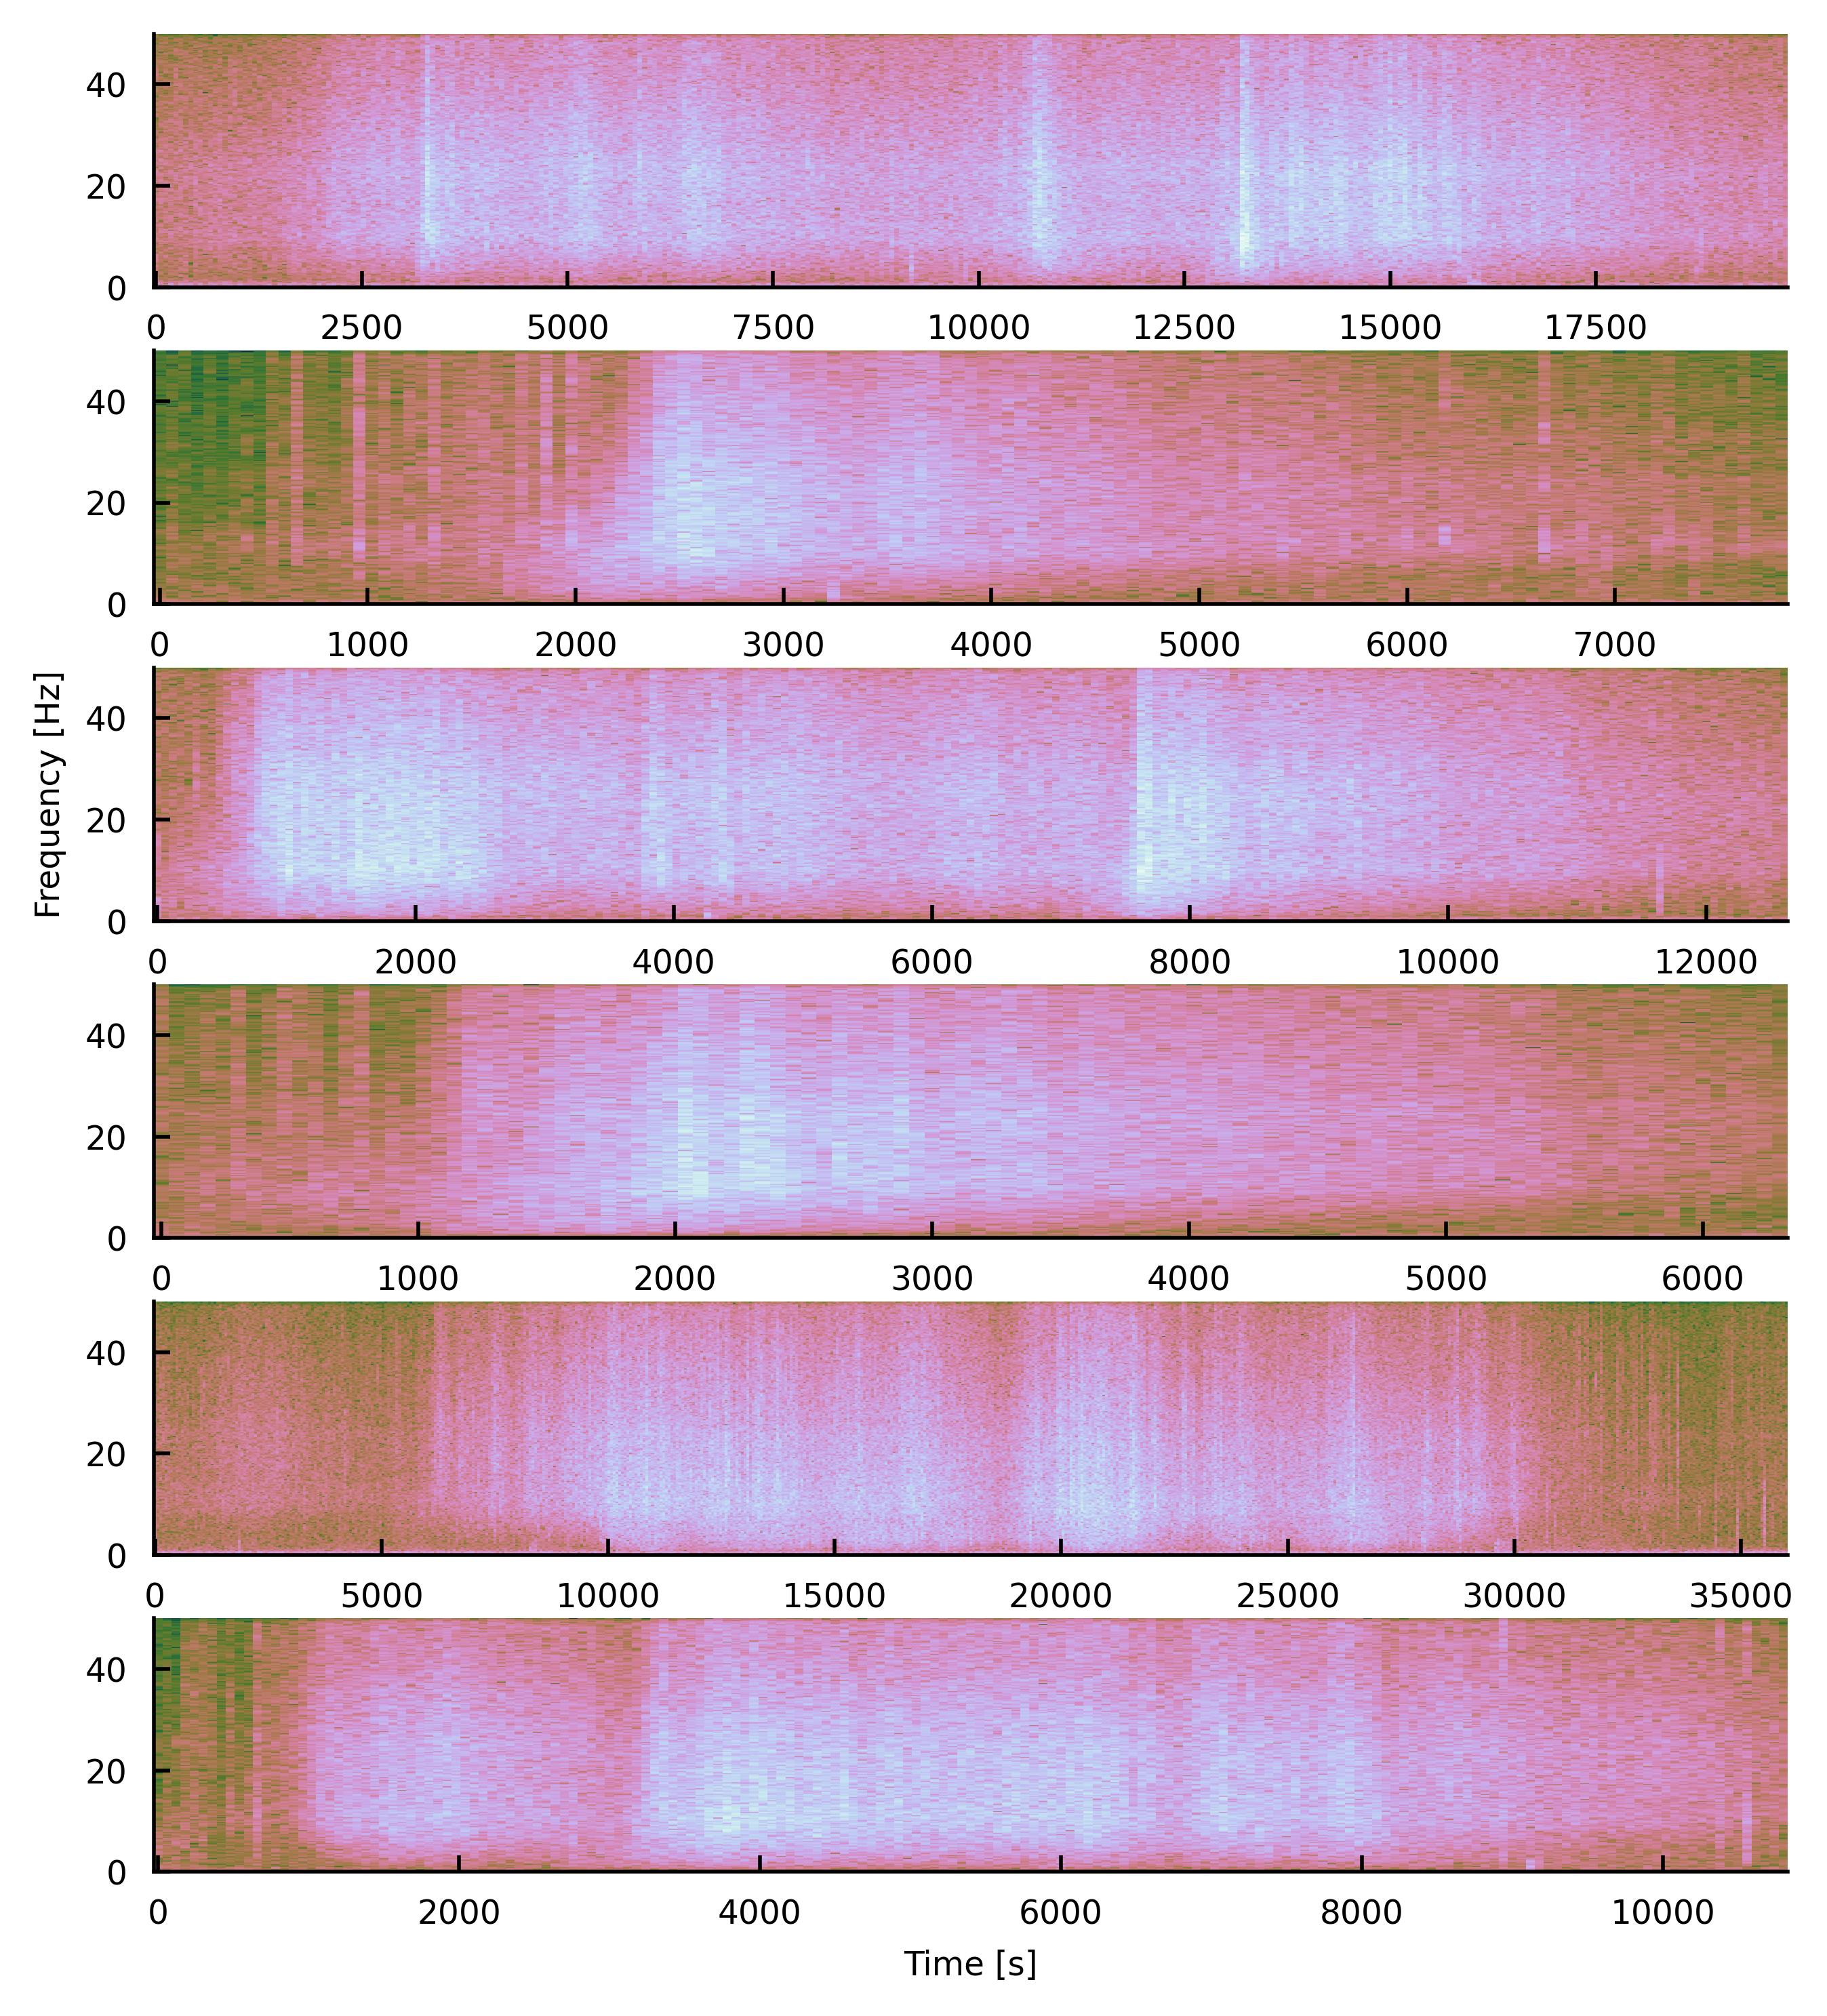

In [ ]:
fig, axs = plt.subplots(nrows=6, ncols=1, figsize = (140/25.4,6), dpi=500)
fig.tight_layout()
fig.subplots_adjust(hspace=0.25)
for ii, flow in enumerate(specsZ):
    # PSD mean
    axs[ii].pcolormesh(times_mesh[ii], freqs_mesh[ii],10*np.log10(specsZ[ii]),vmin=-120,vmax=-35,cmap='cubehelix',zorder=-3)
    axs[ii].plot(times_mesh[ii], )
    axs[ii].tick_params(direction='in', labelsize=7,zorder=3)
    axs[ii].spines[['top','right']].set_visible(False)
    axs[ii].set_ylim(0,50)
    axs[ii].set_facecolor((1, 1, 1, 0))
    # conditions
    if ii == 2:
        axs[ii].set_ylabel('Frequency [Hz]', fontsize=7)
    if ii == 5:
        axs[ii].set_xlabel('Time [s]', fontsize=7)
fig.savefig('figura-prueba-spec.png')